# The CARD Method

## Kevin Sheppard

### Advanced Financial Econometrics: Forecasting

### Background

Material available on [my site](https://www.kevinsheppard.com/teaching/mfe/advanced-financial-econometrics-forecasting/).

More detail in [pre-recorded lectures](https://www.youtube.com/playlist?list=PLVR_rJLcetzmES8tqjgqlQw1Vx2IKMVot).

### Viewing as a Presentation

This notebook has been written with RISE in mind. To view it as a presentation, install RISE using pip install RISE and then press ALT + R to enter slides model.

# Imports and Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from scipy import stats
import seaborn as sns
sns.set_style("darkgrid")
# These values are optimized for full-screen on a high-resolution monitor
plt.rc("figure", figsize=(32,12))
plt.rc("font", size=28)
plt.rc("lines", linewidth=4)

# The M4 Data

Here we take a look at a random selection of series from the M4 that
all have 432 observations.

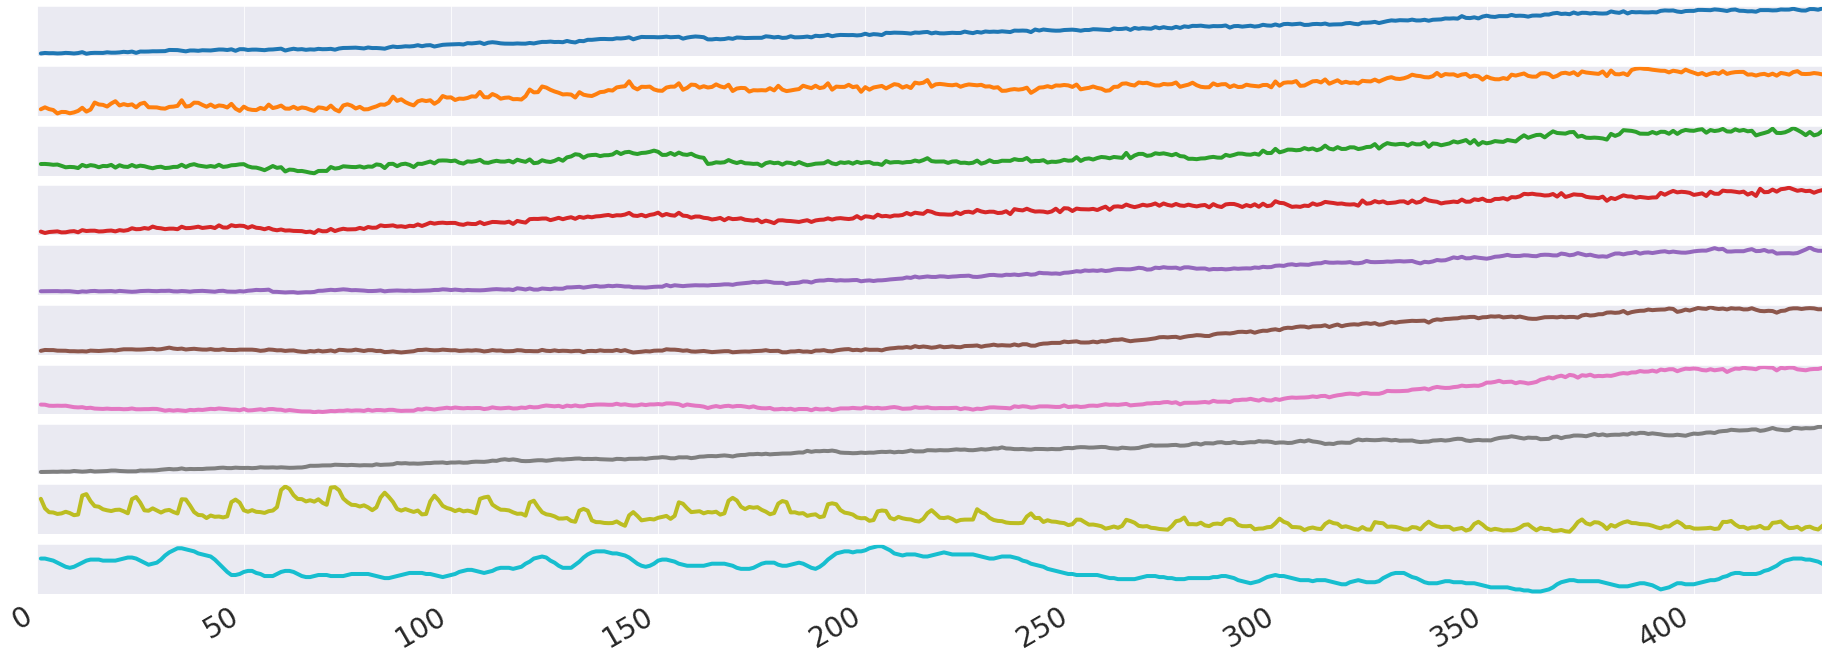

In [3]:
df: pd.DataFrame = pd.read_hdf("./monthly-data.h5", f"nobs_432")
std_data = ((df - df.mean()) / df.std())
# A random selection of series
g = np.random.default_rng([3218935,312391,876871,2180983])
idx = sorted(np.random.randint(df.shape[1],size=10))
axes = std_data.iloc[:,idx].plot(legend=False, subplots=True)
for ax in axes:
    ax.set_yticks([])
    ax.set_xlim(0,431)

# Series with different features

I've chosen three series that different features and so hit 3 out of the 4
paths through the $\delta$-forecasting method.

In [4]:
x = df[["M3276","M23579","M25698"]]
x.head()

,M3276,M23579,M25698
1,854.227267,1021.767544,2747.787182
2,848.738068,993.667269,785.798966
3,844.041434,999.803078,627.154180
4,856.026268,1019.749676,989.574656
5,848.981499,1018.408923,2905.842074


# Preliminaries

We need to compute a few preliminary indicators that are used throughout. The
first encodes the decision whether the log the data.

In [5]:
I_ln = (x > 1).all()
I_ln

M3276     True
M23579    True
M25698    True
dtype: bool

In [6]:
y = x.copy()
y.loc[:, I_ln] = np.log(x.loc[:, I_ln])
y.head()

,M3276,M23579,M25698
1,6.750197,6.929289,7.918551
2,6.743751,6.901402,6.666701
3,6.738202,6.907558,6.441192
4,6.752301,6.927312,6.897275
5,6.744037,6.925997,7.974478


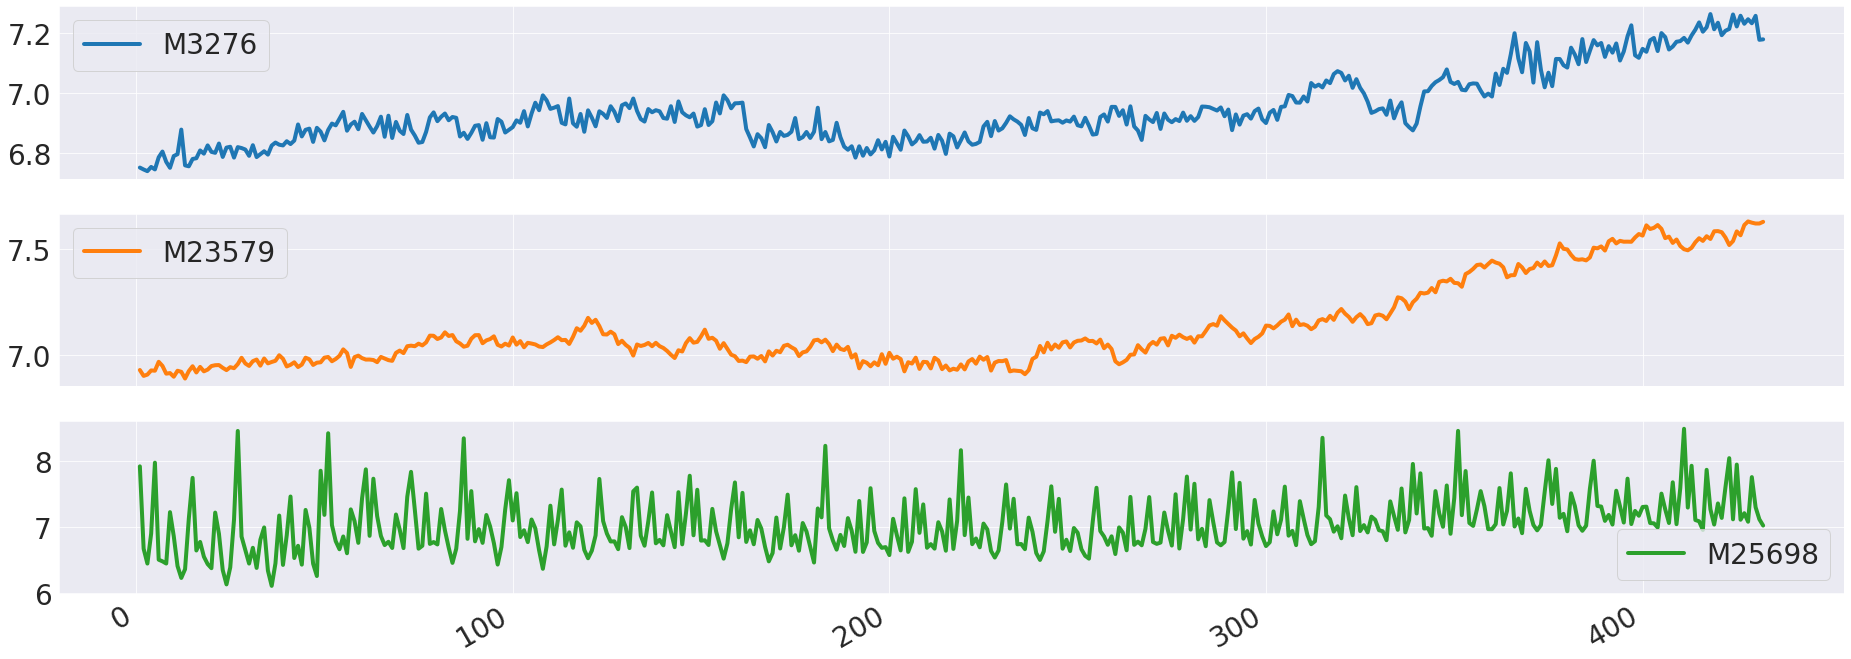

In [7]:
_ = y.plot(subplots=True)

# Persistence/Unit Root

The next test examines the persistence of a time series. The test is checking
whether the variance is lower for the series or the differenced version.

In [8]:
I_rho = y.diff().var() < (1.2 * y.var())
I_rho

M3276      True
M23579     True
M25698    False
dtype: bool

In [9]:
z = y.copy()
z.loc[:, I_rho] = y.loc[:, I_rho].diff()
z.head()

,M3276,M23579,M25698
1,NaN,NaN,7.918551
2,-0.006447,-0.027887,6.666701
3,-0.005549,0.006156,6.441192
4,0.014099,0.019754,6.897275
5,-0.008264,-0.001316,7.974478


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c73a16c50>,
      dtype=object)

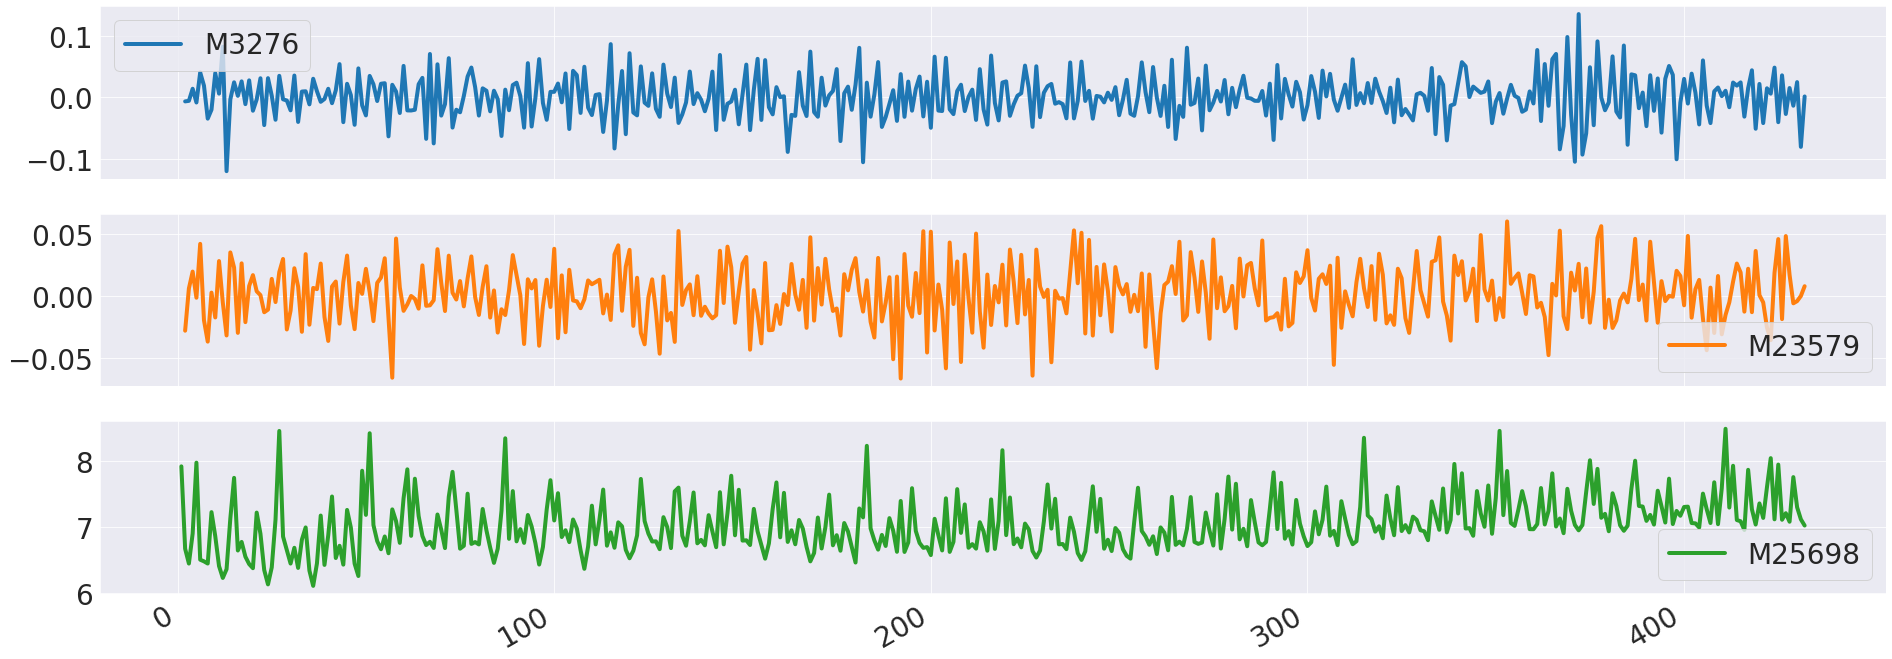

In [10]:
z.plot(subplots=True)

# ANOVA

The next test implements an ANOVA test for seasonal effects.

The test makes use of the $\lfloor T/m \rfloor$ by $m$ matrix containing
the most recent data. We define a function to compute this.

$$
A=\frac{m-1}{m\left(\tau-1\right)}\frac{Var\left[\bar{Z}_{j}\right]}{Var\left[Z_{ij}\right]-Var\left[\bar{Z}_{j}\right]}
$$

The seasonal means are:

$$
\bar{Z}_{j}=\frac{1}{\tau}\sum_{i=1}^{\tau}Z_{ij}
$$

In [11]:
# Monthly data, so assume m = 12
m = 12

def seasonal_matrix(arr):
    arr = arr.dropna()
    a = np.asarray(arr)
    tau = a.shape[0] // m
    a = a[-(tau*12):]
    a = a.reshape((tau, m))
    return a

def anova(arr):
    a = seasonal_matrix(arr)
    tau = a.shape[0]
    zbar = a.mean(0)
    v_zbar = zbar.var()
    v = a.ravel().var()
    stat = m * (tau-1) / (m - 1) * v_zbar / (v - v_zbar)
    i_a = stat > stats.f(m - 1, m * (tau-1)).ppf(.9)
    return i_a

# Use apply to run column-by-column
I_A = z.apply(anova)
I_A

M3276      True
M23579    False
M25698     True
dtype: bool

# Seasonal Autocorrelation

The final indicator is for seasonal autocorrelation.

We test whether $\rho_{12}$ is 0 using the test statistic

$$
R=T\frac{\hat{\rho}_{m}^{2}}{1+2\sum_{i=1}^{m-1}\hat{\rho}_{i}^{2}}
$$

In [12]:
from statsmodels.tsa.stattools import acf

def r(arr):
    arr = arr.dropna()
    rhos = acf(arr, nlags=12, fft=True)
    test = arr.shape[0] * rhos[-1] ** 2 / (1 + (rhos[1:-1]**2).sum())
    return test > stats.chi2(1).ppf(0.9)

I_R = z.apply(r)
I_R   

M3276      True
M23579    False
M25698     True
dtype: bool

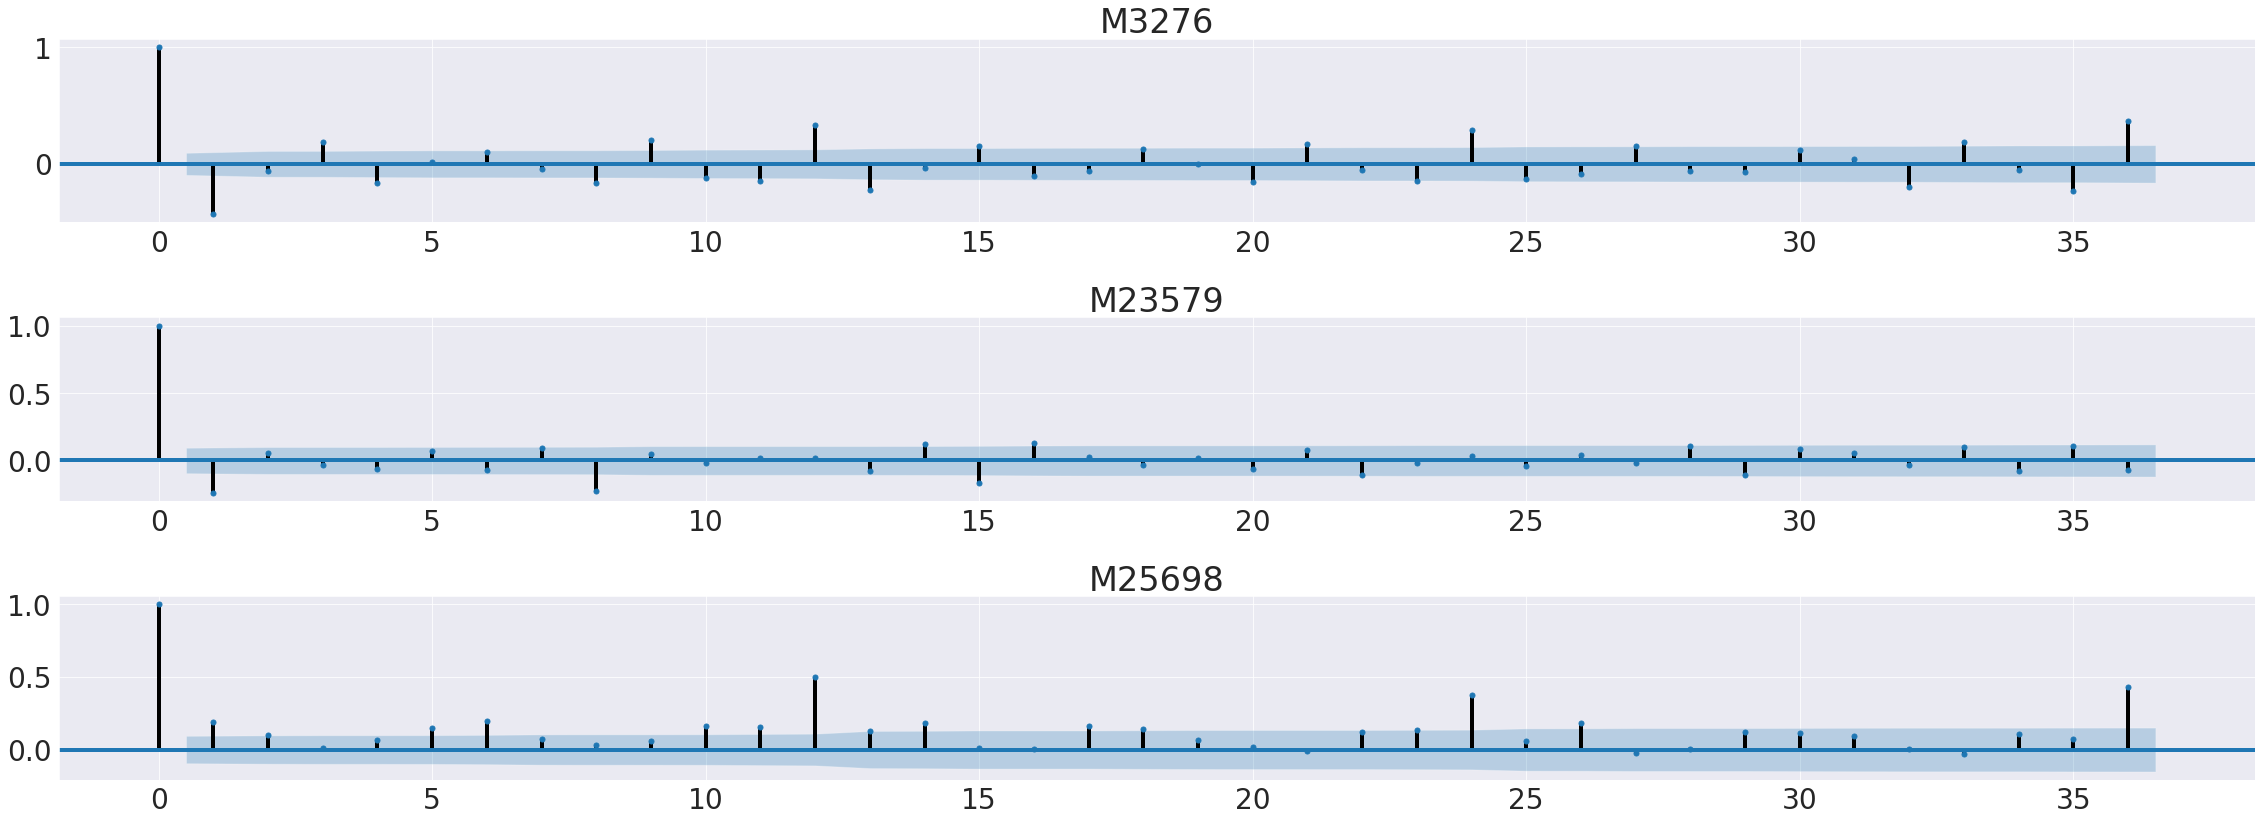

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
_, axes = plt.subplots(3, 1)
for col, ax in zip(z, axes):
    plot_acf(z[col].dropna(), lags=36, ax=ax, title=col)
plt.tight_layout(pad=1.0)

# The $\delta$ Forecast

The $\delta$-forecast is based on a robust model of trend and
seasonal effects. We will cover three of the four paths
through the $\delta$-method.  No series with 432 observations
appeared to be stationary and non-seasonal.


## Non-stationary, non-seasonal

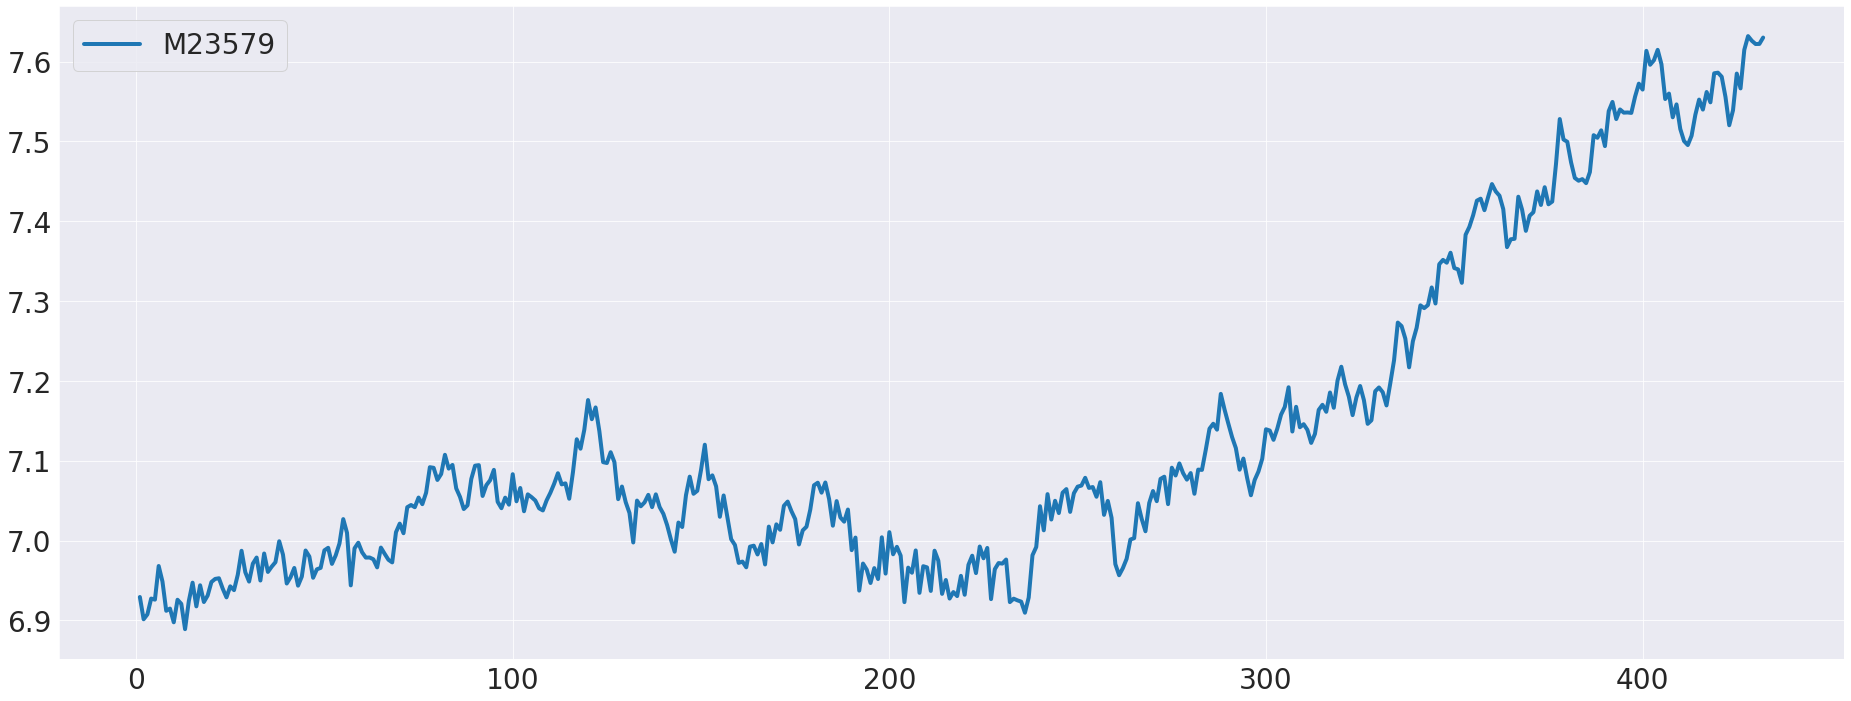

In [14]:
name = "M23579"
yj = y[name]
zj = z[name].dropna()
pd.DataFrame(yj).plot()

# Robust Trend Estimation

 $Z_{\left(i\right)}$ be the $i$ value from the sorted $Z$ where
$\left|Z_{1}\right|\leq\left|Z_{2}\right|\leq\ldots\leq\left|Z_{n}\right|$.

$$
\begin{align*}
d_{1} & =\frac{1}{n-1}\sum_{i=1}^{n-1}Z_{\left(i\right)}\\
d_{2} & =\frac{1}{n-3}\sum_{i=1}^{n-3}Z_{\left(i\right)}\\
d_{r} & =\frac{1}{6}\sum_{t=T-6}^{T}Z_{t}
\end{align*}
$$

In [15]:
zi = np.asarray(zj.iloc[np.argsort(np.abs(zj))])
d1 = zi[:-1].mean()
d2 = zi[:-3].mean()
dr = zj.iloc[-6:].mean()
dm = zj.mean()
ds = yj.diff(12).mean() / 12
d1, d2, dr, dm, ds

(0.0017845399882803008,
 0.0020964254705170987,
 0.010612546134254774,
 0.001626246478665083,
 0.0015905734517151677)

# Further Robustness and Forecasts
The function $\text{sigmin}\left(a,b\right)=\text{sgn}\left(a\right)\min\left(\left|a\right|,\left|b\right|\right)I_{\left[ab>0\right]}$
is used throughout to add robustness.

If $T>2m+1$, define $d_{S}=m^{-1}\overline{\Delta_{m}Y_{t}}$
and $d_{m}=\text{sgnmin}\left(d_{m},d_{S}\right)$.

$$
\begin{align*}
\hat{Y}_{T+1} & =Y_{T}+\text{sgnmin}\left(d_{r}^{*},d_{1}\right)\\
\hat{Y}_{T+h} & =Y_{T+h-1}+\text{sgnmin}\left(d_{r}^{*},d_{2}\right),\;h=2,\ldots,H
\end{align*}
$$

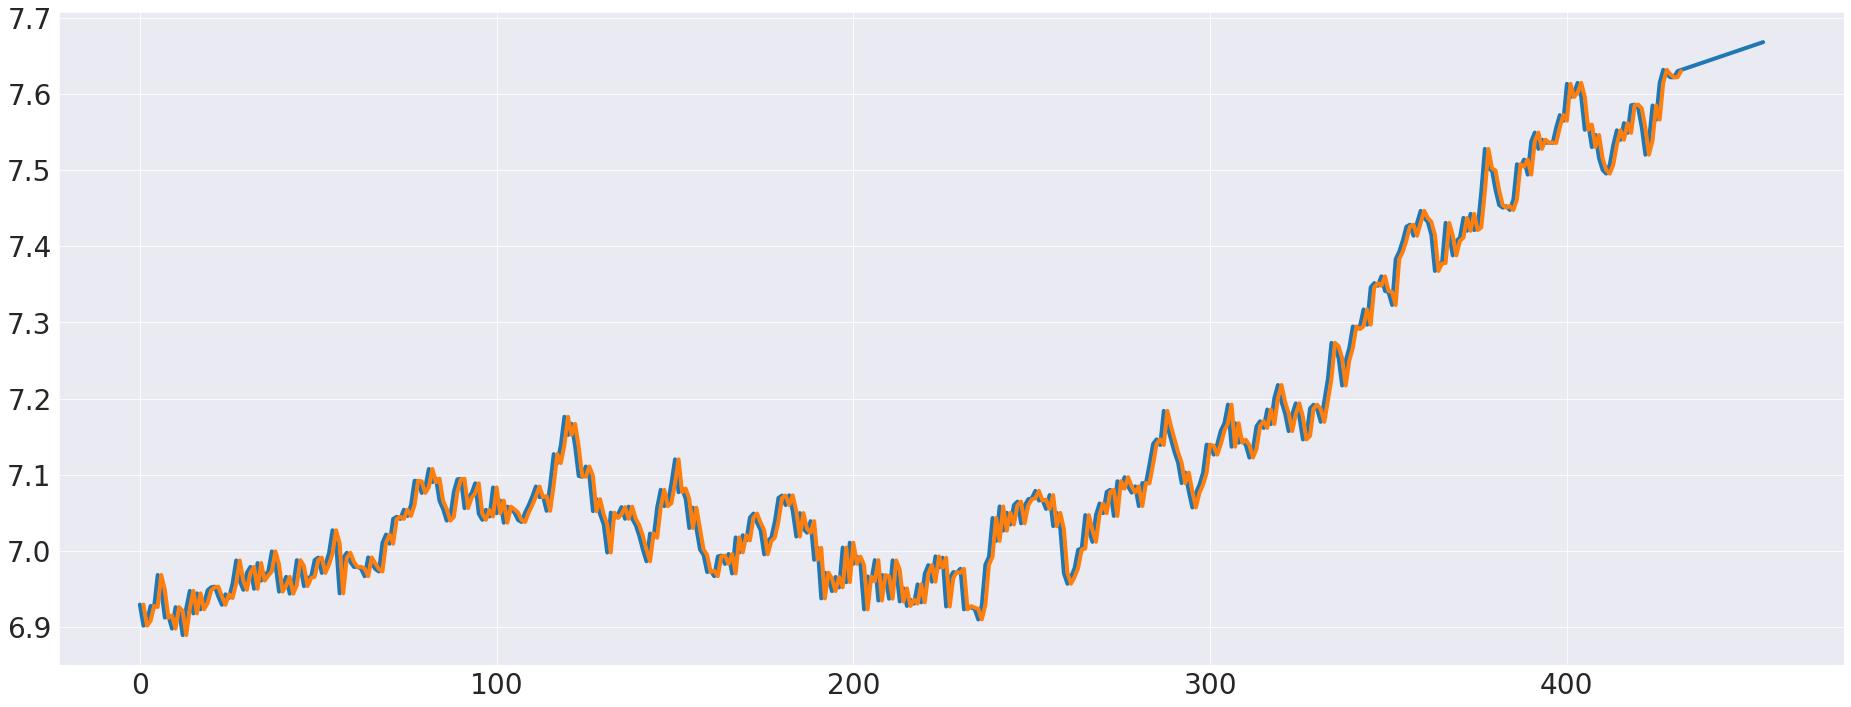

In [16]:
def sgnmin(a, b):
    return np.sign(a) * min(np.abs(a), np.abs(b)) * ((a * b) > 0)

dm = sgnmin(dm, ds)
dr_star = sgnmin(dr, dm)
y_hat = np.zeros(24)
y_hat[0] = yj.iloc[-1] + sgnmin(dr_star, d1)
for i in range(1, 24):
    y_hat[i] = y_hat[i-1] + sgnmin(dr_star, d2)

combined = pd.Series(list(yj) + list(y_hat))
plt.plot(combined)
plt.plot(yj)
plt.show()
y_delta = combined

# Non-stationary, seasonal

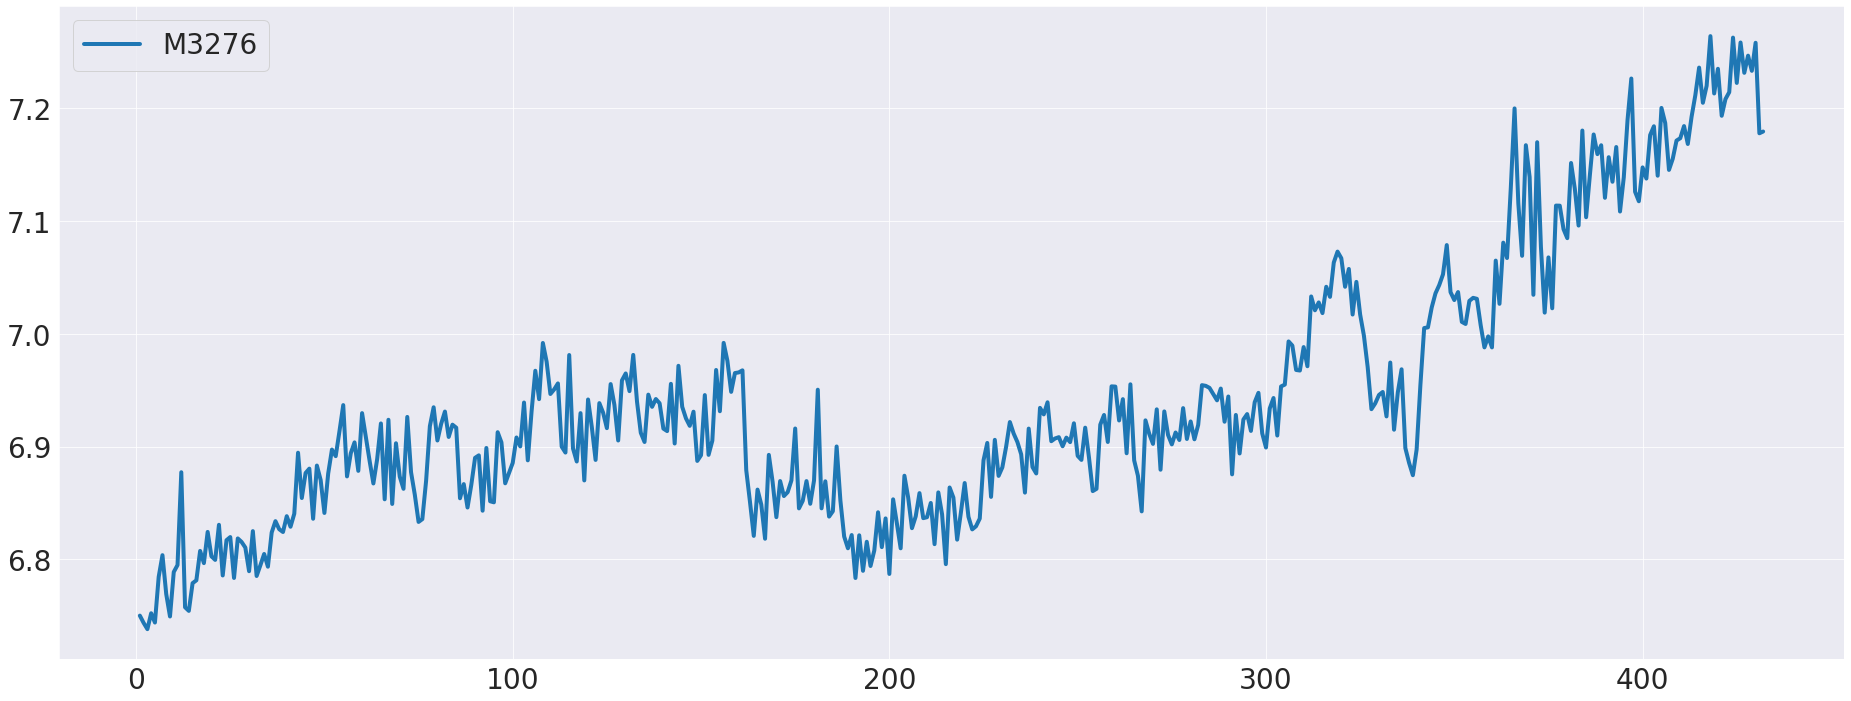

In [17]:
name = "M3276"
yj = y[name]
zj = z[name].dropna()
_ = pd.DataFrame(yj).plot()

# Annual Data

The seasonal method makes use of annual means that are easy to compute using the seasonal matrix representation
for $d_1$, $d_2$ and $d_r$.

In [18]:
zij = seasonal_matrix(zj)
zbar = zij.mean(1)

zbari = np.asarray(zbar[np.argsort(np.abs(zbar))])
d1 = zbari[:-1].mean()
d2 = zbari[:-3].mean()
dr = zbar[-6:].mean()
dm = zj.mean()
ds = yj.diff(12).mean() / 12

dr_star = sgnmin(dr,dm)

# Seasonal Component Estimation

The seasonal dummies are estimated using a $MA_{3\times5}$ of the final rows of the seasonal matrix.
They are finally demeaned using the cross-sectional average of the seasonal effects.

In [19]:
w = np.array([1,2,3,9])/15
s_star = w @ zij[-4:]
s_star

s = s_star - s_star.mean()

# Forecasts

The forecasts are produced using the same equations are the non-seasonal case, only adding in the seasonalities each period.

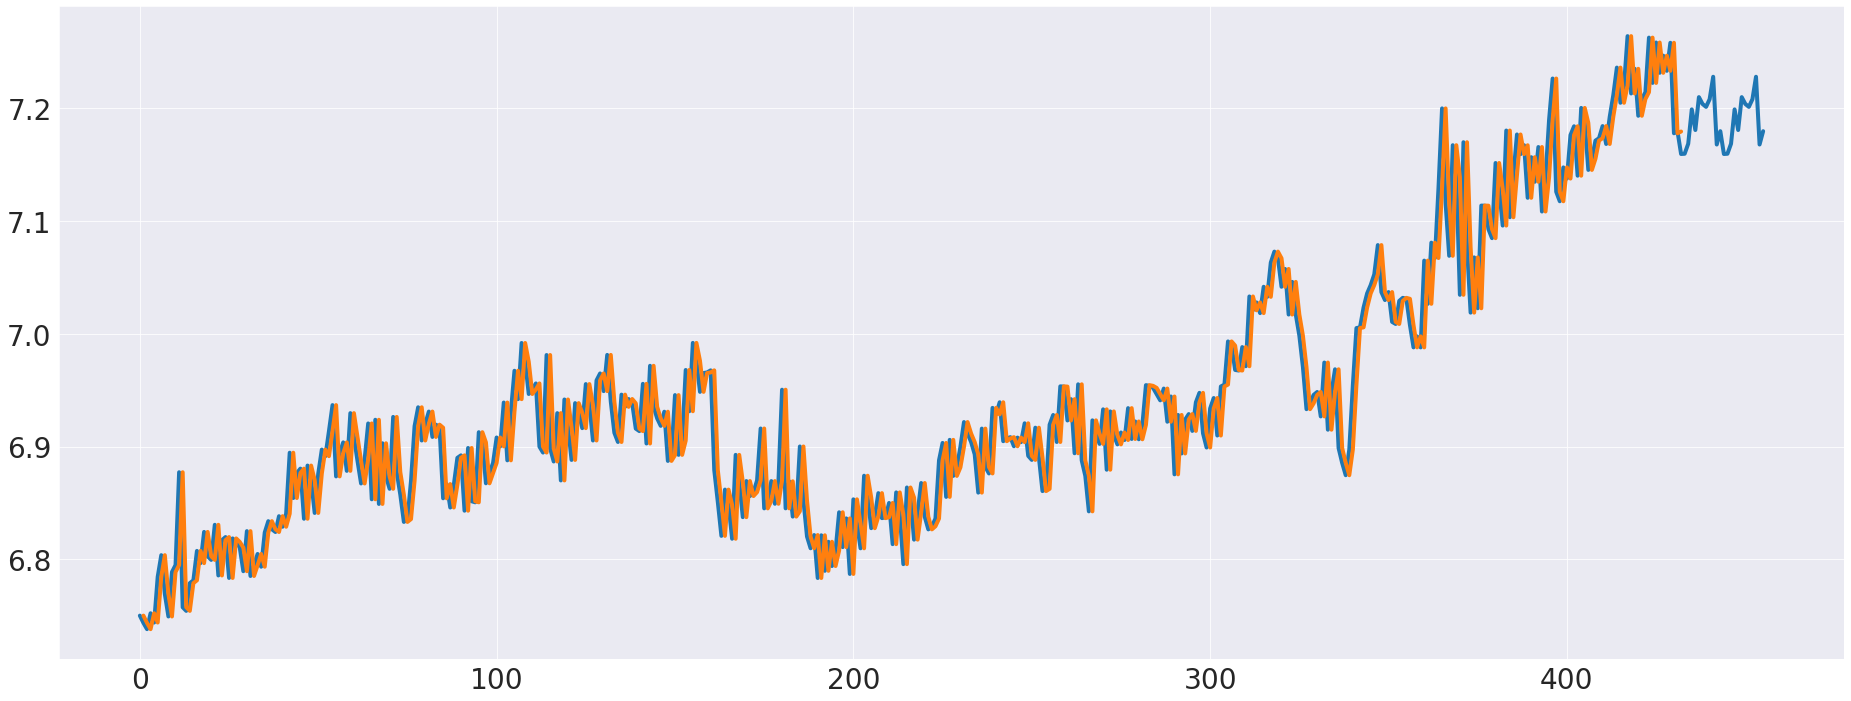

In [20]:
y_hat = np.zeros(24)
y_hat[0] = yj.iloc[-1] + sgnmin(dr_star, d1) + s[0]
for i in range(1, 24):
    loc = i - 12 * (i // 12)
    y_hat[i] = y_hat[i-1] + sgnmin(dr_star, d2) + s[loc]
combined = pd.Series(list(yj) + list(y_hat))
plt.plot(combined)
plt.plot(yj)
plt.show()

# Stationary, Seasonal

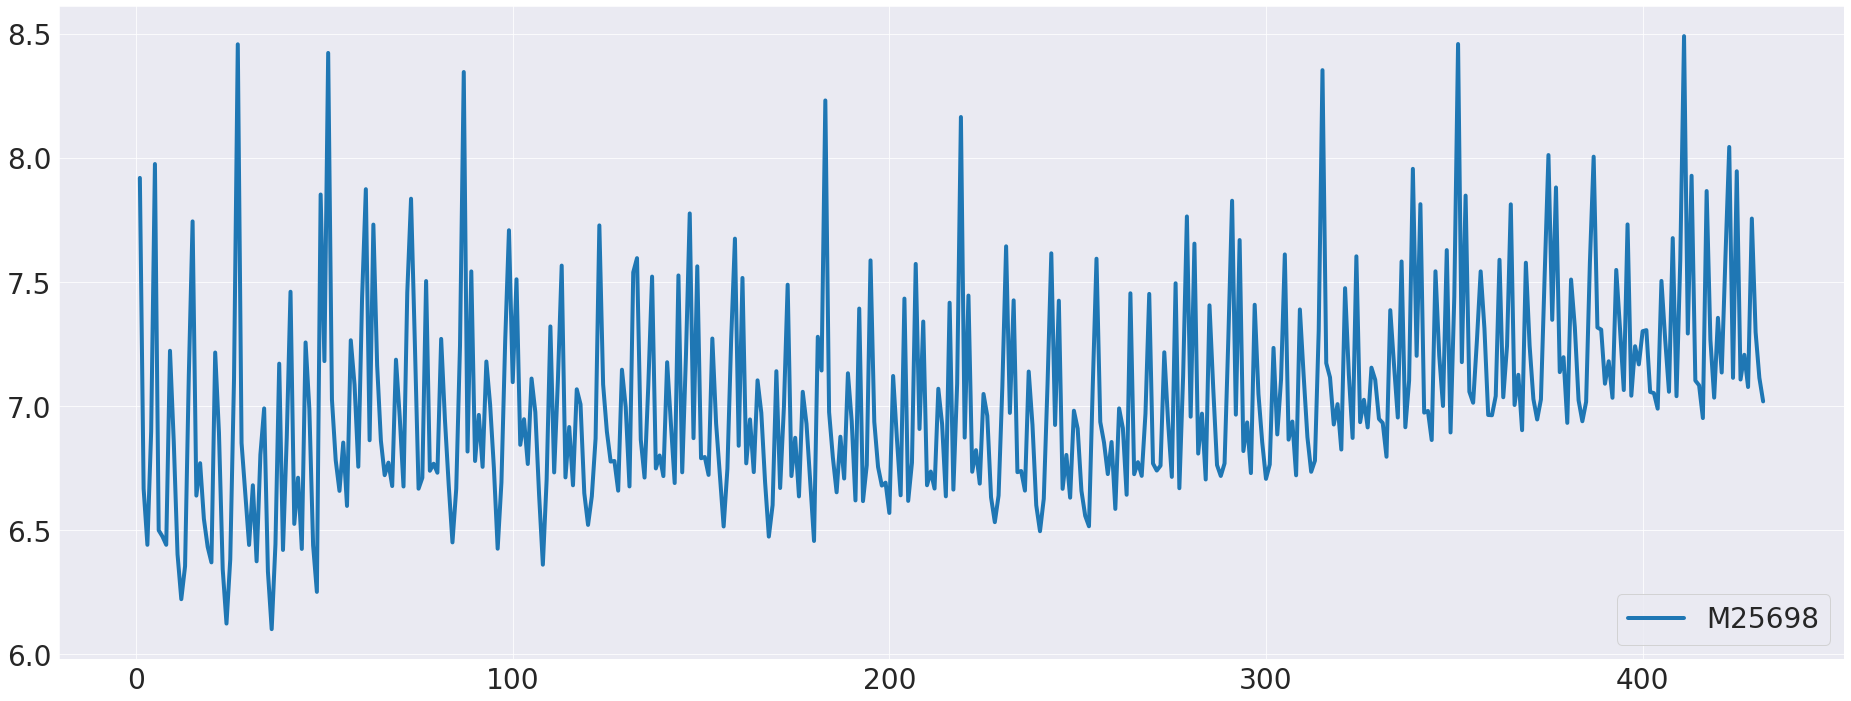

In [21]:
name = "M25698"
yj = y[name]
zj = z[name].dropna()
_ = pd.DataFrame(yj).plot()

# Seasonal Components

The seasonal components are estimated using an $MA_{7\times 5}$.


In [22]:
zij = seasonal_matrix(zj)

w = np.array([1, 2, 3, 4, 5, 20]) / 35
s_star = w @ zij[-6:]
s = s_star - s_star.mean()

# Forecasts

The forecasts depend either on the final annual mean or the previous 6 ($h>1$).

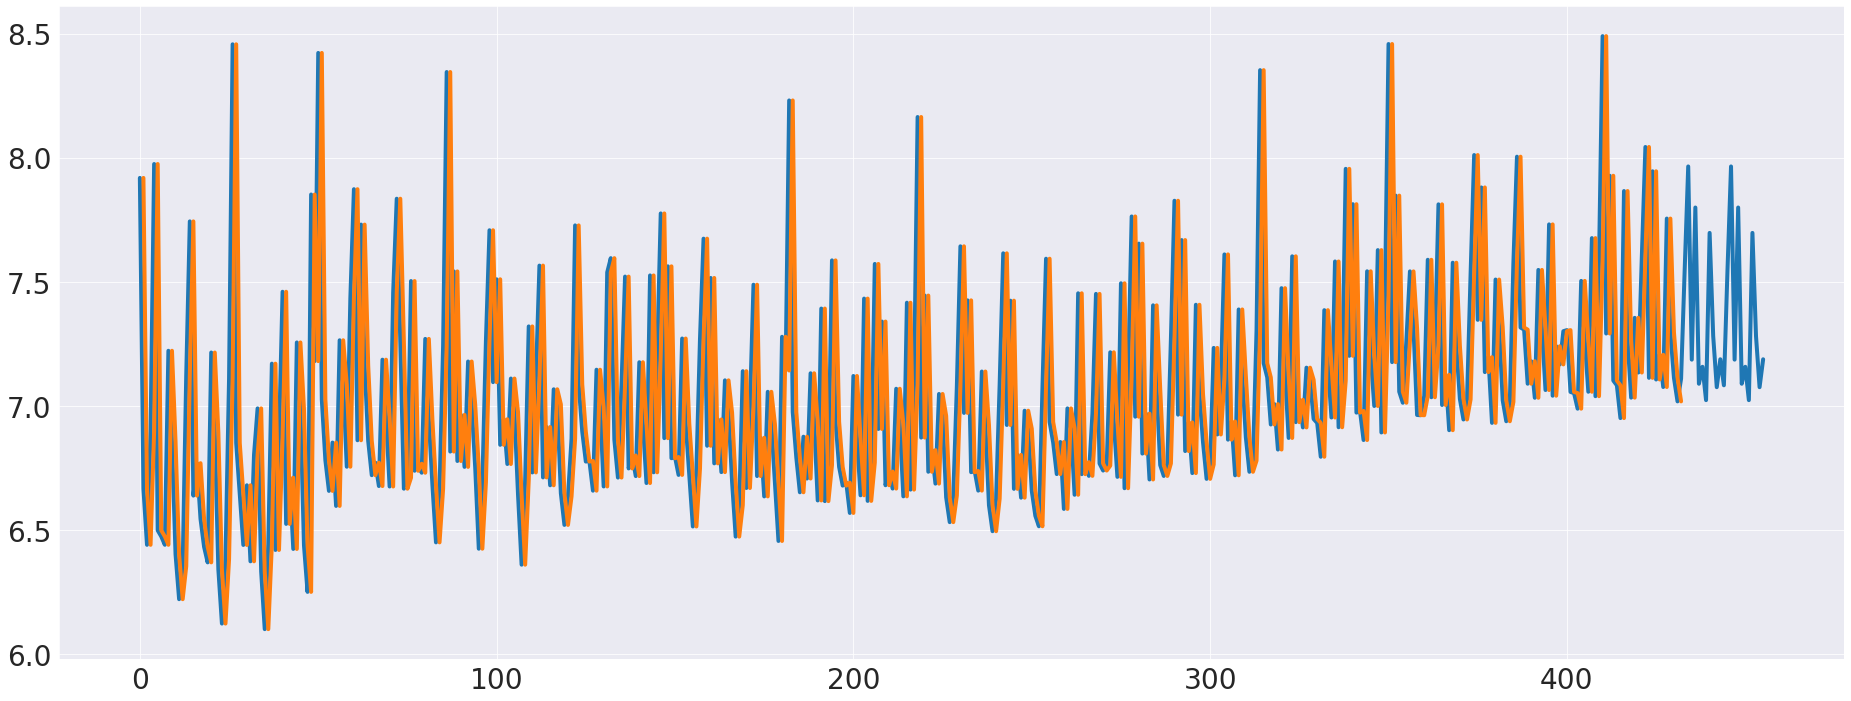

In [23]:
zbar = zij.mean(1)

y_hat = np.zeros(24)
y_hat[0] = zbar[-1] + s[0]
mu_1 = zbar[-1]
mu_6 = zbar[-6:].mean()
for i in range(1, 24):
    loc = i - 12 * (i // 12)
    y_hat[i] = 0.5 * (mu_1 + mu_6) + s[loc]

combined = pd.Series(list(yj) + list(y_hat))
plt.plot(combined)
plt.plot(yj)
plt.show()

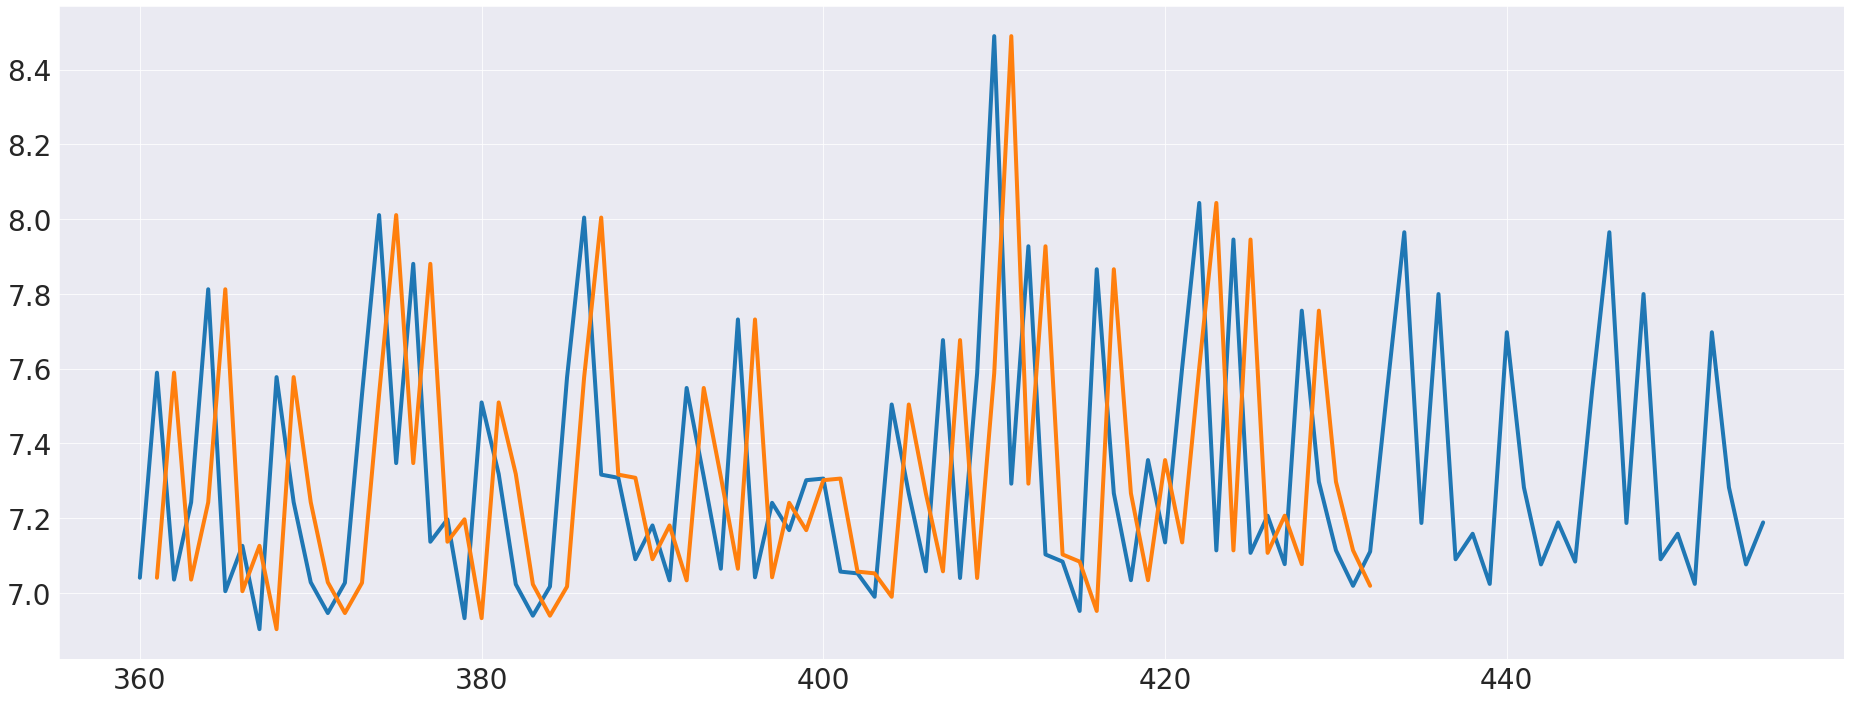

In [24]:
plt.plot(combined[-(72+24):])
plt.plot(yj[-72:])
plt.show()

# Rho Forecast

The first step is to build the regressors.

$$
\begin{align*}
Y_{t}= & \mu+\left(\rho Y_{t-1}+\rho_{m}Y_{t-m}I_{R}\right)I_{AR} + \gamma\lfloor t/m\rfloor I_{\text{tr}}+\sum_{j=1}^{m-1}\delta_{j}I_{S_{j}}I_{A}+\epsilon_{t}
\end{align*}
$$


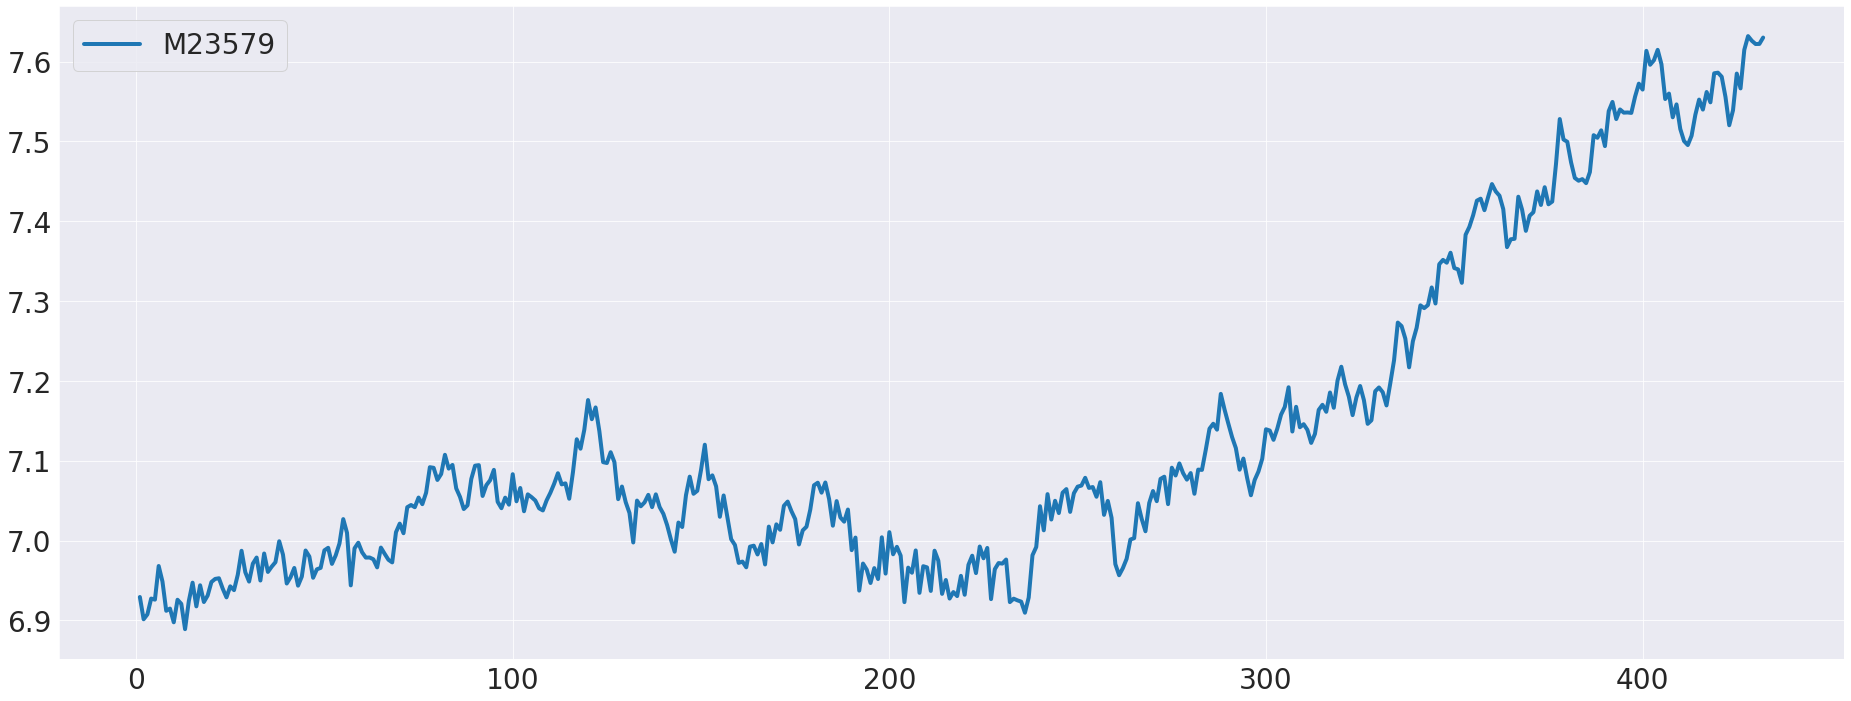

In [25]:
name = "M23579"
yj = y[name]
_ = pd.DataFrame(yj).plot()

In [26]:
I_ar = I_rho[name]
I_UR = I_tr = False
rhs = {"mu": pd.Series(np.ones_like(yj), index=yj.index)}
if I_ar:
    rhs["rho"] = yj.shift(1)
    if I_R[name]:
        rhs["rho_m"] = yj.shift(12)
if I_tr:
    rhs["trend"] = np.arange(1, yj.shape[0] + 1) / m
if I_A[name]:
    d = np.arange(y.shape[0], dtype="int")
    d = d - 12 * (d // 12)
    d = [f"s_{v}" for v in d]
    d = pd.Series(d, dtype="category")
    dummies =  pd.get_dummies(d, drop_first=True)        
    for col in dummies:
        rhs[col] = dummies[col]
rhs = pd.DataFrame(rhs)


# Initial Model

We can fit the initial model.

In [27]:
rhs
joined = pd.concat([yj, rhs],axis=1).dropna()
lhs, rhs = joined.iloc[:,0],  joined.iloc[:,1:]
res = OLS(lhs, rhs).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 M23579   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 2.915e+04
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        00:37:23   Log-Likelihood:                 996.06
No. Observations:                 431   AIC:                            -1988.
Df Residuals:                     429   BIC:                            -1980.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mu             0.0103      0.042      0.246      0.806      -0.072       0.092
rho            0.9988      0.006    170.737      0.000       0.987       1.010
==============================================================================
Omnibus:                        0.976   Durbin-Watson:                   2.474
Prob(Omnibus):                  0.614   Jarque-Bera (JB):                1.037
Skew:                          -0.049   Prob(JB):                        0.595
Kurtosis:                       2.781   Cond. No.                         262.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Unit Root and Differencing

In [28]:
rho = res.params["rho"]
if rho > 0.5 and (rho + 2 * res.bse["rho"]) > 0.9:
    lhs = yj.diff()
    I_UR = True
    rhs = rhs.drop("rho", axis=1)
    joined = pd.concat([lhs, rhs], axis=1).dropna()
    lhs, rhs = joined.iloc[:,0],  joined.iloc[:,1:]
    
    res = OLS(lhs, rhs).fit()
    print(res.summary())
elif rho < 0:
    lhs = yj
    rhs = rhs.drop("rho", axis=1)
    if "rho_m" in rhs:
        rhs = rhs.drop("rho_m", axis=1)
    joined = pd.concat([lhs, rhs], axis=1).dropna()
    lhs, rhs = joined.iloc[:,0],  joined.iloc[:,1:]
    res = OLS(lhs, rhs).fit()
    print(res.summary())       

                            OLS Regression Results                            
Dep. Variable:                 M23579   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 08 May 2020   Prob (F-statistic):                nan
Time:                        00:37:23   Log-Likelihood:                 996.04
No. Observations:                 431   AIC:                            -1990.
Df Residuals:                     430   BIC:                            -1986.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mu             0.0016      0.001      1.405      0.1

# Trends

If $I_{UR}$ is one, then we need to test for a trend.

In [29]:
eps = res.resid
t = eps.shape[0]
if I_UR and (t - res.df_model) > 10:
    trend = t - np.arange(t)
    stat = OLS(eps, trend).fit().tvalues[0]
    pval = 2 * (1 - stats.t(t-1).cdf(np.abs(stat)))
    if pval < .01:
        I_tr = True
        rhs["trend"] = np.arange(1, yj.shape[0] + 1) / m
        res = OLS(lhs, rhs).fit()

if I_tr and "rho" in res.params and res.params.rho < -0.5:
    rhs = rhs.drop("trend", axis=1)
    res = OLS(lhs, rhs).fit()

# Forecasting

The forecast is produced from the model after shrinking the mean towards zero.  This is the method used if $I_{UR}$ is $1$. If $I_{UR}=0$ then the model is forecast without further adjustment.

In [30]:
mu = res.params["mu"]
mu_se = res.bse["mu"]
sigma = np.sqrt(res.mse_resid)
t = lhs.shape[0]
mu_tilde = max(0, mu - 1.645 * sigma / np.sqrt(t - 1))
mu_tilde

0

# Forecasts

The model only includes a constant (but is differenced), so the forecast is

$$ Y_{T+h|t} = Y_T + h \tilde{\mu}$$

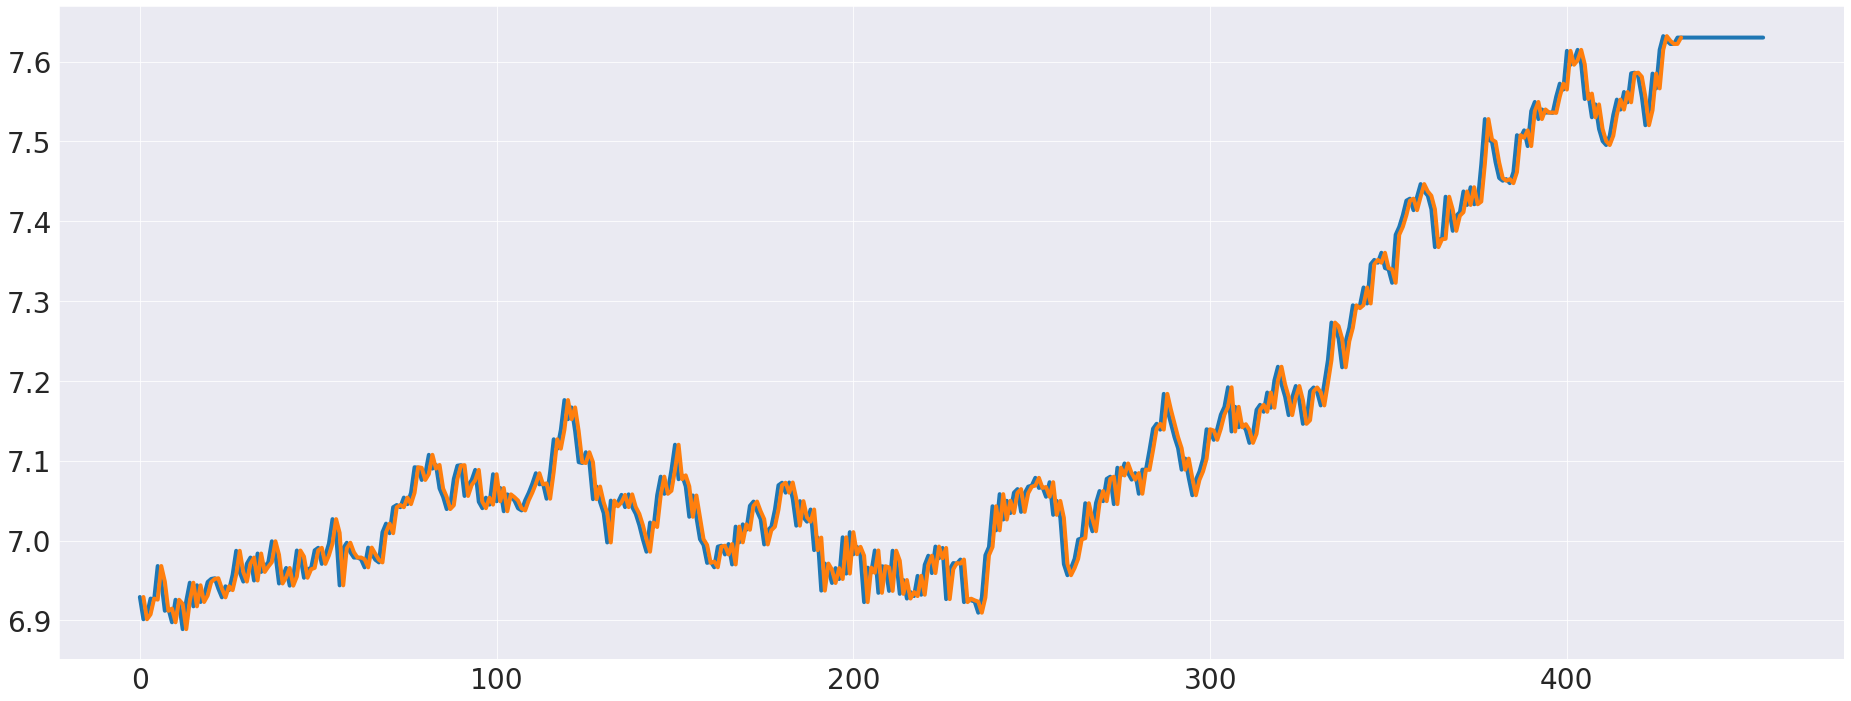

In [31]:
y_hat = yj.iloc[-1] + np.arange(1, 25) * mu_tilde
combined = pd.Series(list(yj) + list(y_hat))
plt.plot(combined)
plt.plot(yj)
plt.show()
y_rho = combined

# Averaging and Calibration

$$
\begin{align*}
Y_{t}= & \mu+\rho Y_{t-1}I_{\rho}+\left(\rho_{m}Y_{t-m}+\rho_{m+1}Y_{t-m-1}\right)I_{R}I_{\rho}I_{4}
  +\sum_{j=1}^{m-1}\delta_{j}I_{S_{j}}I_{A}+\left\{ \delta_{s}S_{t}+\delta_{c}C_{t}\right\}\left(1-I_{A}\right)
  +\left(\gamma_{1}d_{t}+\gamma_{2}td_{t}I_{5}\right)I_{6}+\epsilon_{t}
\end{align*}
$$

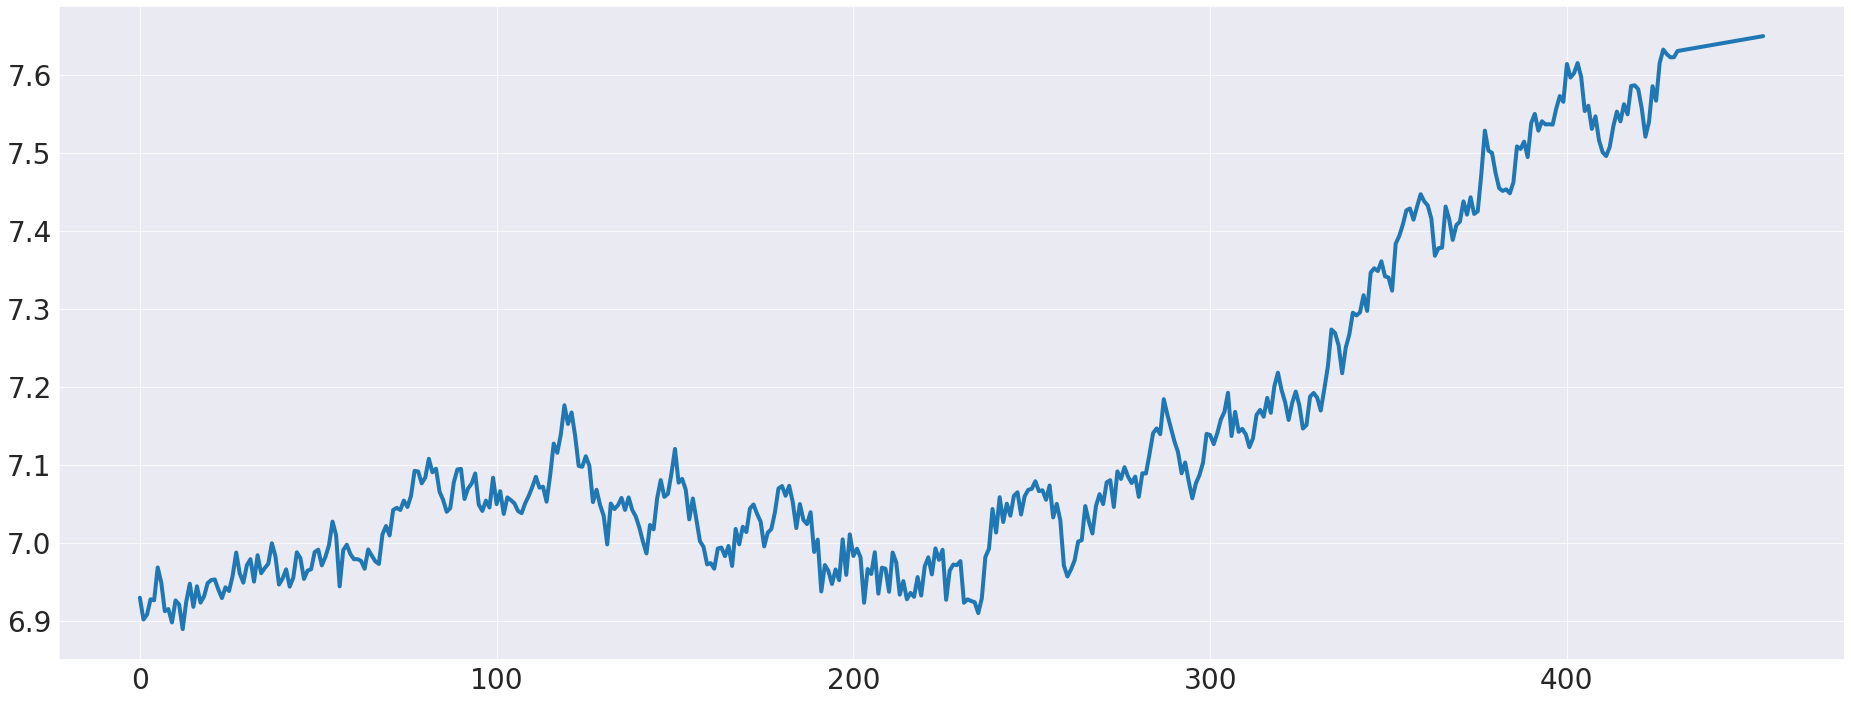

In [32]:
yhat_avg = 0.5 * (y_delta + y_rho)
_ = yhat_avg.plot()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     8234.
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        00:37:25   Log-Likelihood:                 1064.2
No. Observations:                 455   AIC:                            -2116.
Df Residuals:                     449   BIC:                            -2092.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0230      0.048      0.476      0.634      -0.072       0.118
rho            0.9970      0.007    146.823      0.000       0.984       1.010
s              0.0002      0.002      0.150      0.881      -0.003       0.003
c             -0.0011      0.002     -0.727      0.468      -0.004       0.002
dt            -0.0123      0.103     -0.120      0.905      -0.215       0.190
tdt         3.269e-05      0.000      0.137      0.891      -0.000       0.001
==============================================================================
Omnibus:                        0.181   Durbin-Watson:                   2.473
Prob(Omnibus):                  0.913   Jarque-Bera (JB):                0.240
Skew:                          -0.046   Prob(JB):                        0.887
Kurtosis:                       2.934   Cond. No.                     1.33e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

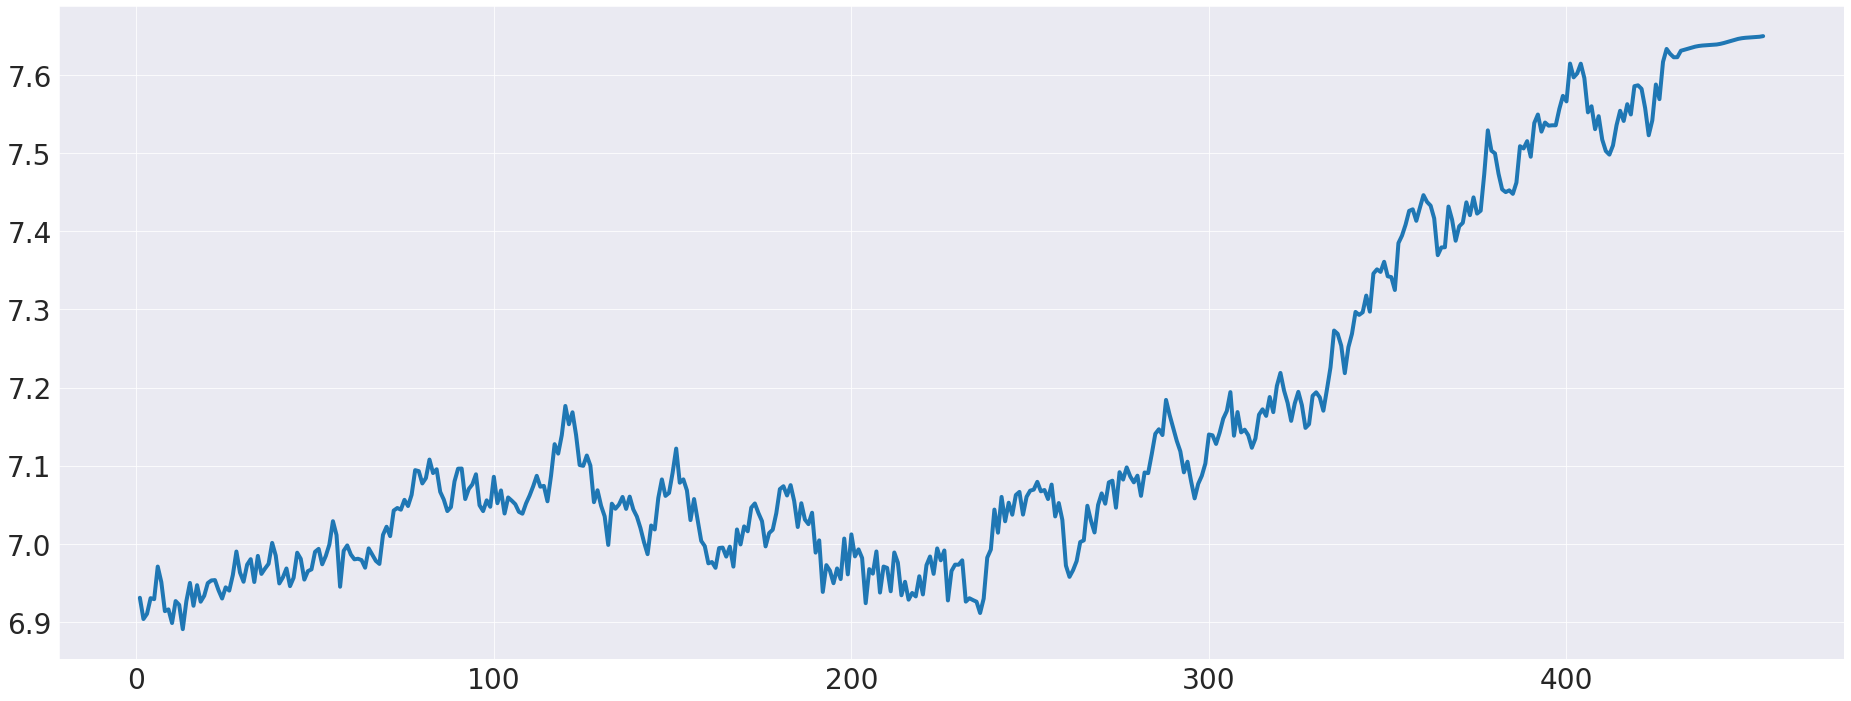

In [33]:
name = "M23579"
tph = yhat_avg.shape[0]
t = y[name].shape[0]
rhs = {"const": pd.Series(np.ones_like(yhat_avg))}
I_4 = t > 4 * m
I_5 = I_rho[name] * (m in (4,12,13))
if I_rho[name]:
    rhs["rho"] = yhat_avg.shift(1)
if I_rho[name] and I_R[name] and I_4:
    rhs["rho_m"] = yhat_avg.shift(12)
    rhs["rho_m_1"] = yhat_avg.shift(13)
if I_A[name]:
    seasons = pd.Series(np.arange(t) % 12, dtype="category")
    dummies = pd.get_dummies(seasons, drop_first=True)
    for col in dummies:
        rhs[f"gamma_{col}"] = dummies[col]
else:
    s = np.sin(2*np.pi * np.arange(1, tph+1) / m)
    c = np.cos(2*np.pi * np.arange(1, tph+1) / m)
    rhs["s"] = pd.Series(s)
    rhs["c"] = pd.Series(c)
I_6 = m != 24 and t > 3*m and (tph - len(rhs)) > 10
if I_6:
    dt = np.ones_like(yhat_avg)
    dt = 1.0 * (np.arange(1, tph+1) >= t - 0.5 * min(4 * m, tph))
    rhs["dt"] = pd.Series(dt)
    if I_5:
        rhs["tdt"] = pd.Series(np.arange(1, tph+1) * dt)
rhs = pd.DataFrame(rhs)
joined = pd.concat([yhat_avg, rhs], axis=1)
joined = joined.dropna()
lhs, rhs = joined.iloc[:,0], joined.iloc[:,1:]
res = OLS(lhs, rhs).fit()
forecasts = res.fittedvalues
forecasts.plot()
res.summary()
    